In [ ]:
from numpy import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import pandas as pd
import seaborn as sns
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import numpy as np
import time

import torch as torch
from scipy.stats import norm
torch.set_printoptions(precision=8)
torch.set_default_dtype(torch.float32)
torch.set_default_tensor_type(torch.cuda.FloatTensor)

# Initial version

<font size="3"> $$f(x)=(-1)*x^3$$
\begin{align}
d X_{t} &= \Big( v(X_{t},\mu_{t}^{X}) + b(t,X_{t}, \mu_{t}^{X})\Big)d t + \sigma(t,X_{t}, \mu_{t}^{X})d W_{t},  \quad X_{0} \in L_{0}^{m}( R^{d}),\\
v(x,\mu)&= -\frac14 x^3+ \int_{R^{d}  } f(x-y) \mu(dy) ,\qquad b()=x,\qquad \sigma()=x\\
\end{align}
\begin{align}
\hat{X}_{n+1}^{i,N}& =\hat{X}_{n}^{i,N}
            + v_M(\hat{X}_{n}^{i,N},\hat{\mu}^{X,N}_n) h
            + b(t_n,\hat{X}_{n}^{i,N},\hat{\mu}^{X,N}_n) h
            +\sigma(t_n,\hat{X}_{n}^{i,N},\hat{\mu}^{X,N}_n) \Delta W_{n}^i.
            \\
v_M(\hat{X}_{n}^{i,N},\hat{\mu}^{X,N}_n)&= \frac{v(\hat{X}_{n}^{i,N},\hat{\mu}^{X,N}_n)}{1+M^{-\alpha} |v(\hat{X}_{n}^{i,N},\hat{\mu}^{X,N}_n)|} ,
~ \alpha \in(0,\frac{1}{2}],
\quad
  \hat{\mu}^{X,N}_n(dx):= \frac1N \sum_{j=1}^N \delta_{X_{n}^{j,N}}(dx).
\nonumber
\end{align}

## Methods （Drift-tamed Euler，modified-Euler method，tanh-Euler method，Split-step method）

In [ ]:
np.sqrt(2)

1.4142135623730951

In [ ]:
def torch_make_brownian_motion(bm,h):  # Update BM, push it into h future.
    hh=np.sqrt(h)
#     bm+=hh*np.random.normal(0,1,size=(len(bm)))
    bm+=hh*torch.randn(len(bm), dtype=torch.float64)
    return(0)

def make_brownian_motion(bm,h):  # Update BM, push it into h future.
    hh=np.sqrt(h)
    for i in range(len(bm)):
        rrr=hh*np.random.normal(0,1)
        bm[i]+=rrr
    return(0)


def torch_drift_tamed_method(x,bm,h,T,N):     ## x[0,:] is BM information, x[1.:] is particle's information
    n=len(bm)
    alpha=0.5
    M=T/h
    mma=M**(-alpha)
    sigma=1

    sample_vre = torch.reshape(x[1,:],(N,1))
    nominator_tmp = sample_vre-x[1,:]
    nom_tmp =  -nominator_tmp**3
    norm0 = torch.mean(nom_tmp,1)-0.25*x[1,:]**3

    dWt=bm-x[0,:]
    x[0,:]=bm
    x[1,:]=x[1,:] + h*norm0/(1+mma*torch.abs(norm0)) + x[1,:]*h + sigma*x[1,:]*dWt
    return(0)

def torch_modified_euler_method(x,bm,h,T,N):     ## x[0,:] is BM information, x[1.:] is particle's information
    n=len(bm)
    M=T/h
    mma=M**(-1)
    sigma=1

    sample_vre = torch.reshape(x[1,:],(N,1))
    nominator_tmp = sample_vre-x[1,:]
    nom_tmp =  -nominator_tmp**3
    norm0 = torch.mean(nom_tmp,1)-0.25*x[1,:]**3+x[1,:]


    dWt=bm-x[0,:]
    x[0,:]=bm
    x[1,:]=x[1,:] + h*norm0/(1+mma*torch.abs(norm0)**2) + h*sigma*x[1,:]/(1+mma*torch.abs(sigma*x[1,:])**2)*dWt
    return(0)

def torch_tanh_euler_method(x,bm,h,T,N):     ## x[0,:] is BM information, x[1.:] is particle's information
    n=len(bm)
    M=T/h
    sigma=1

    sample_vre = torch.reshape(x[1,:],(N,1))
    nominator_tmp = sample_vre-x[1,:]
    nom_tmp =  -nominator_tmp**3
    norm0 = torch.mean(nom_tmp,1)-0.25*x[1,:]**3

    dWt=bm-x[0,:]
    x[0,:]=bm
    x[1,:]=x[1,:] + torch.tanh((norm0+x[1,:])*h)+torch.tanh((sigma*x[1,:])*h)/h*dWt
    return(0)


def torch_ssm_method(x,bm,h,T,N):

    alpha=0.5
    M=int(T/h)
    sigma=1
    y = x.detach().clone()
    sqrth=math.sqrt(h)
    pd=True
    count=1
    while pd:  # Newton's part.
        sample_vre = torch.reshape(y[1,:],(N,1))

        nominator_tmp = sample_vre-y[1,:]
        nom_tmp =  -nominator_tmp**3
        vy = torch.mean(nom_tmp,1)-0.25*y[1,:]**3

        nom_tmp =   -3*nominator_tmp**2
        vyprime = torch.mean(nom_tmp,1)-0.75*y[1,:]**2

        upper=(vy*h-y[1,:]+x[1,:])

        fovergprime=upper/(h*vyprime-1)
        y[1,:]+= -fovergprime
        # pd=False
        # count+=1

        if (torch.max(upper))<=sqrth and (torch.min(upper))>=-sqrth:     pd=False


    dWt=bm-x[0,:]
    x[0,:]=bm
    x[1,:]=y[1,:]*(1+h)+ sigma*y[1,:]*dWt
    return(0)



In [ ]:
torch.sign(torch.randn(2, dtype=torch.float64))*torch.randn(2, dtype=torch.float64)

tensor([-0.17499964, -2.20072629], dtype=torch.float64)

In [ ]:
def save_information(method_value_list,method_names_list):
    n_of_schemes=len(method_names_list)
    n_of_particles=len(method_value_list[0])
    infor_list=[]
    for i in range(n_of_schemes):
        print(i)
        for j in range(n_of_particles):
            infor_list.append( [ method_value_list[i][j][1] , method_names_list[i] ]  )
#         names[i+2*N]=r'drift_tamed $version 2$'

    return(infor_list)

def selected_examples(value,newvalue,newnames,low,up):
    for i  in range(len(value)):
        if value[i][0]>=low and value[i][0]<=up:
            newvalue.append(value[i][0])
            newnames.append(value[i][1])
    return(0)
#Ready for the dis plot.

def torch_save_information(method_value_list,method_names_list):   #[n_of_schemes][n_of_paticles][values] ; [schmes'names]
    n_of_schemes=len(method_names_list)
    n_of_particles=len(method_value_list[0][1])
    infor_list=[]
    infor_list=torch.zeros( n_of_schemes*n_of_particles,2, dtype=torch.float32)
    count=0
    for i in range(n_of_schemes):
        print(i)
        for j in range(n_of_particles):
            infor_list[count][0]=method_value_list[i][1][j]
            infor_list[count][1]=method_names_list[i]
            count+=1

    return(infor_list)

def torch_selected_examples(value,newvalue,newnames,newtimes,low,up):  # Split the [n][value/names] list into two lists.
    for i  in range(len(value)):
        if value[i][0]>=low and value[i][0]<=up:
            newvalue.append(value[i][0])
            newnames.append(value[i][1])
            newtimes.append(value[i][2])
    return(0)


In [ ]:
def calculation_strong_error(exact,approx):
    n=len(exact[1])
    strong_error=0
    for i in range(n):
        strong_error+=(exact[1][i]-approx[1][i])**2
    strong_error=np.sqrt(strong_error/n)
    return(strong_error.item())

def calculation_path_error(prev,exact,approx):
    aaaa=(exact[1]-approx[1])**2
    prev=torch.max( prev,aaaa)
    return( prev)


In [ ]:
np.random.binomial(1,0.5)

1

In [ ]:
N=1000
ppp=torch.zeros(N, dtype=torch.float32,  device='cuda')

In [ ]:
aa=torch.randn(2, dtype=torch.float64)
bb=torch.randn(2, dtype=torch.float64)
aa,bb,torch.max(aa,bb)

(tensor([1.24459754, 0.85242962], dtype=torch.float64),
 tensor([-1.39365955,  0.67751983], dtype=torch.float64),
 tensor([1.24459754, 0.85242962], dtype=torch.float64))

## Simulation-torch for errors.

In [ ]:
# Compare of different scheme. test part.
# hmin=2**(-13), N=1000,drift_tamed，modified-Euler,tanh-Euler,ssm, without adaptive.
T=1
M=int(2**13)
h=2**(-13)
n=1000
N=n
round_scheme=10

# h_of_scheme=[2**(-15),2**(-14),2**(-13),2**(-12),2**(-11),2**(-10),2**(-9),2**(-8)]
# n_of_scheme=len(h_of_scheme)

h_of_scheme=[2**(-13),2**(-10),2**(-9.5),2**(-9),2**(-8.5),2**(-8),2**(-7.5),2**(-7)]
n_of_scheme=len(h_of_scheme)




particle_adaptive=torch.zeros(n_of_scheme,2,N)
measure_ada=[ [ 0 for i in range(n)   ] for k in range(n_of_scheme)  ]



timestep=[2**(-10),2**(-9.5),2**(-9),2**(-8.5),2**(-8),2**(-7.5),2**(-7)]
moder=[2**(-10),2**(-9.5),2**(-9),2**(-8.5),2**(-8),2**(-7.5),2**(-7)]
for i in range(len(moder)):
    moder[i]=int(moder[i]*(1e5))

nmoder=len(moder)



#trigger=[ [ 0 for k in range(n_of_scheme)  ] for i in range(n)   ]
bm=torch.zeros(N, dtype=torch.float64)
#bm_for_other_method=[0 for i in range(n)]

time_ssm=np.zeros(nmoder)
time_drift_tamed=np.zeros(nmoder)
time_modified_euler=np.zeros(nmoder)
time_tanh_euler=np.zeros(nmoder)

particle_drift_tamed_exact1=torch.zeros(2,N, dtype=torch.float32,  device='cuda')
particle_modified_euler_exact1=torch.zeros(2,N, dtype=torch.float32,  device='cuda')
particle_tanh_euler_exact1=torch.zeros(2,N, dtype=torch.float32,  device='cuda')
particle_split_step_exact1=torch.zeros(2,N, dtype=torch.float32,  device='cuda')
particle_euler_exact1=torch.zeros(2,N, dtype=torch.float32,  device='cuda')
particle_drift_tamed_method1=torch.zeros(nmoder,2,N, dtype=torch.float32,  device='cuda')
particle_modified_euler_method1=torch.zeros(nmoder,2,N, dtype=torch.float32,  device='cuda')
particle_tanh_euler_method1=torch.zeros(nmoder,2,N, dtype=torch.float32,  device='cuda')
particle_split_step_method1=torch.zeros(nmoder,2,N, dtype=torch.float32,  device='cuda')
particle_euler_method=torch.zeros(nmoder,2,N, dtype=torch.float32,  device='cuda')

path_diff_drift_tamed=torch.zeros(nmoder,N, dtype=torch.float32,  device='cuda')
path_diff_modified_euler=torch.zeros(nmoder,N, dtype=torch.float32,  device='cuda')
path_diff_tanh_euler=torch.zeros(nmoder,N, dtype=torch.float32,  device='cuda')
path_diff_ssm=torch.zeros(nmoder,N, dtype=torch.float32,  device='cuda')


#Inital distribution.
for i in range(n):
    xxx000=np.random.normal(2,2)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_drift_tamed_exact1[1][i]=xxx000
    #particle_drift_tamed_exact2[1][i]=xxx000
    particle_modified_euler_exact1[1][i]=xxx000
    #particle_modified_euler_exact2[1][i]=xxx000
    particle_tanh_euler_exact1[1][i]=xxx000
    #particle_tanh_euler_exact2[1][i]=xxx000
    particle_split_step_exact1[1][i]=xxx000
    #particle_split_step_exact2[1][i]=xxx000
    particle_euler_exact1[1][i]=xxx000


    for j in range(nmoder):
        particle_drift_tamed_method1[j][1][i]=xxx000
        #particle_drift_tamed_method2[j][1][i]=xxx000
        particle_modified_euler_method1[j][1][i]=xxx000
        #particle_modified_euler_method2[j][1][i]=xxx000
        particle_tanh_euler_method1[j][1][i]=xxx000
        #particle_tanh_euler_method2[j][1][i]=xxx000
        particle_split_step_method1[j][1][i]=xxx000
        particle_euler_method[j][1][i]=xxx000


xxx=0
M=int(1/h)
# T=0.001
T=1
for ii in range(1,M*T+1):
# for ii in range(1,10+1):
    time_end=round(ii*h,round_scheme)
    if ii%1000==0: print(ii)

    torch_make_brownian_motion(bm,h)
    torch_drift_tamed_method(particle_drift_tamed_exact1,bm,h,T,N)
    torch_modified_euler_method(particle_modified_euler_exact1,bm,h,T,N)
    torch_tanh_euler_method(particle_tanh_euler_exact1,bm,h,T,N)
    torch_ssm_method(particle_split_step_exact1,bm,h,T,N)
    #euler_method(particle_euler_exact1,bm,0.001,T)
    #drift_tamed_method_version2(particle_drift_tamed_exact2,bm,0.001,T)
    for j in range(len(moder)):
        if (ii%moder[j]==0):
            t1=time.time()
            torch_drift_tamed_method(particle_drift_tamed_method1[j],bm,timestep[j],T,N)
            t2=time.time()
            torch_modified_euler_method(particle_modified_euler_method1[j],bm,timestep[j],T,N)
            t3=time.time()
            torch_tanh_euler_method(particle_tanh_euler_method1[j],bm,timestep[j],T,N)
            t4=time.time()
            torch_ssm_method(particle_split_step_method1[j],bm,timestep[j],T,N)
            t5=time.time()
            time_ssm[j]+=t5-t4
            time_tanh_euler[j]+=t4-t3
            time_modified_euler[j]+=t3-t2
            time_drift_tamed[j]+=t2-t1
            path_diff_ssm[j]=calculation_path_error(path_diff_ssm[j], particle_split_step_exact1 ,particle_split_step_method1[j] )
            path_diff_tanh_euler[j]=calculation_path_error(path_diff_tanh_euler[j], particle_tanh_euler_exact1 ,particle_tanh_euler_method1[j] )
            path_diff_modified_euler[j]=calculation_path_error(path_diff_modified_euler[j], particle_modified_euler_exact1 ,particle_modified_euler_method1[j] )
            path_diff_drift_tamed[j]=calculation_path_error(path_diff_drift_tamed[j], particle_drift_tamed_exact1 ,particle_drift_tamed_method1[j] )




1000
2000
3000
4000
5000
6000
7000
8000


In [ ]:
path_diff_ssm[0]

tensor([1.15605056e+00, 3.85753900e-01, 6.10717821e+00, 1.13058281e+00,
        1.06878757e+00, 7.12254643e-02, 5.01408339e+00, 1.12499201e+00,
        1.66680932e+00, 4.11961615e-01, 3.90949249e+00, 2.99860883e+00,
        2.68874588e+01, 5.12121797e-01, 2.35626268e+00, 5.06728649e-01,
        8.78113937e+00, 2.83972287e+00, 4.22155476e+00, 9.80243742e-01,
        9.49906185e-02, 7.87697744e+00, 4.32683229e-01, 1.25525069e+00,
        7.03152061e-01, 1.04080951e+00, 2.22607926e-01, 1.14030428e+01,
        8.15587044e-01, 5.21342218e-01, 2.65621257e+00, 4.13594341e+00,
        3.14055920e-01, 6.40875101e-01, 7.35249162e-01, 2.05914402e+00,
        1.52830935e+01, 2.94014740e+00, 1.61672103e+00, 2.84025002e+00,
        3.41510677e+00, 1.50503170e+00, 9.96509743e+00, 7.80355111e-02,
        9.38360023e+00, 4.61624289e+00, 3.40008765e-01, 5.92913747e-01,
        2.74428904e-01, 9.87454176e-01, 8.13434899e-01, 7.39239645e+00,
        5.82172394e+00, 2.58624196e-01, 2.39628270e-01, 4.732322

In [ ]:
time_ssm

array([0.08528709, 0.06441259, 0.05053401, 0.03915238, 0.02965379,
       0.02154779, 0.01591825])

### Calculation of errors and plots


In [ ]:
particle_drift_tamed_exact1=particle_drift_tamed_exact1.to( "cpu")
#particle_drift_tamed_exact2=particle_drift_tamed_exact2.to( "cpu")
particle_modified_euler_exact1=particle_modified_euler_exact1.to( "cpu")
#particle_modified_euler_exact2=particle_modified_euler_exact2.to( "cpu")
particle_tanh_euler_exact1=particle_tanh_euler_exact1.to( "cpu")
#particle_tanh_euler_exact2=particle_tanh_euler_exact2.to( "cpu")
particle_split_step_exact1=particle_split_step_exact1.to( "cpu")

particle_drift_tamed_method1=particle_drift_tamed_method1.to( "cpu")
#particle_drift_tamed_method2=particle_drift_tamed_method2.to( "cpu")
particle_modified_euler_method1=particle_modified_euler_method1.to( "cpu")
#particle_modified_euler_method2=particle_modified_euler_method2.to( "cpu")
particle_tanh_euler_method1=particle_tanh_euler_method1.to( "cpu")
#particle_tanh_euler_method2=particle_tanh_euler_method2.to( "cpu")
particle_split_step_method1=particle_split_step_method1.to( "cpu")

 ## calculation of the errors
strong_error_drift_tamed1=np.zeros( (nmoder) )
#strong_error_drift_tamed2=np.zeros( (nmoder) )
strong_error_modified_euler1=np.zeros( (nmoder) )
#strong_error_modified_euler2=np.zeros( (nmoder) )
strong_error_tanh_euler1=np.zeros( (nmoder) )
#strong_error_tanh_euler2=np.zeros( (nmoder) )
strong_error_split_step1=np.zeros( nmoder )

for i in range(nmoder):
    strong_error_drift_tamed1[i]=calculation_strong_error(particle_drift_tamed_exact1,particle_drift_tamed_method1[i])
    #strong_error_drift_tamed2[i]=calculation_strong_error(particle_drift_tamed_exact2,particle_drift_tamed_method2[i])
    strong_error_modified_euler1[i]=calculation_strong_error(particle_modified_euler_exact1,particle_modified_euler_method1[i])
    #strong_error_modified_euler2[i]=calculation_strong_error(particle_modified_euler_exact2,particle_modified_euler_method2[i])
    strong_error_tanh_euler1[i]=calculation_strong_error(particle_tanh_euler_exact1,particle_tanh_euler_method1[i])
    #strong_error_tanh_euler2[i]=calculation_strong_error(particle_tanh_euler_exact2,particle_tanh_euler_method2[i])
    strong_error_split_step1[i]=calculation_strong_error(particle_split_step_exact1,particle_split_step_method1[i])

In [ ]:
strong_error_split_step1,strong_error_tanh_euler1,strong_error_modified_euler1,strong_error_drift_tamed1

(array([0.88221997, 0.89822567, 0.89581794, 0.95222902, 0.94195992,
        1.12048411, 1.1638447 ]),
 array([0.8566125 , 0.86262178, 0.84806716, 0.89789563, 0.97195035,
        1.31647706, 1.51302719]),
 array([1.27288198, 1.37323022, 1.45945048, 1.54643762, 1.60892427,
        1.6791836 , 1.72361994]),
 array([3.31434631, 3.36390662, 3.51313233, 3.29862928, 3.48470592,
        3.41216326, 3.43470073]))

<ipython-input-20-ddd5ae99f792>:55: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-." (-> color='g'). The keyword argument will take precedence.
  z2,=plt.plot(timestep, (timestep**0.5),'g-.',label='Order 1',color='green')


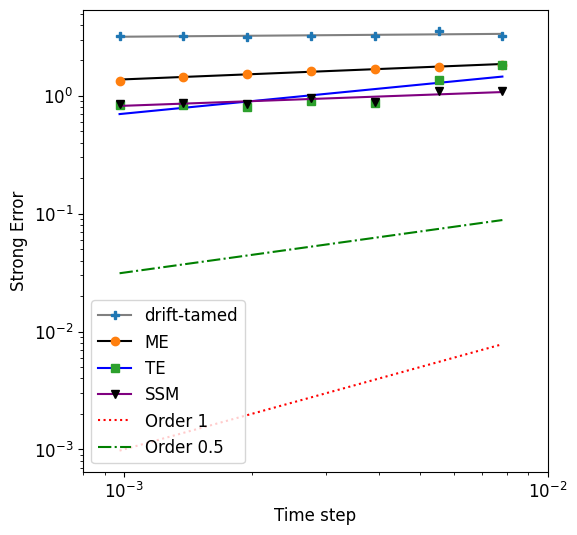

In [ ]:
# make graphs.
from matplotlib import pyplot
timestep=[2**(-10),2**(-9.5),2**(-9),2**(-8.5),2**(-8),2**(-7.5),2**(-7)]
plt.rcParams['font.size'] = '12'
plt.rcParams["figure.figsize"] = (6,6)


plt.xlabel('Time step')
plt.ylabel('Strong Error')

#plt.title('Different method compare to the exact solution')

plt.xlim(0.0008,0.01)
#plt.ylim(0.000001,1)

plt.yscale('log')#plt.xscale('log')
plt.xscale("log")

##

timestep=np.array(timestep)

m1, b1 = np.polyfit(np.log(timestep),np.log(strong_error_drift_tamed1),1)
a,=plt.plot(timestep, (timestep**m1)*np.exp(b1),color='grey' )
b,=plt.plot(timestep,strong_error_drift_tamed1,'P',color='C0')

m2, b2 = np.polyfit(np.log(timestep),np.log(strong_error_modified_euler1),1)
c,=plt.plot(timestep, (timestep**m2)*np.exp(b2),color='black' )
d,=plt.plot(timestep,strong_error_modified_euler1,'o',color='C1')

m3, b3 = np.polyfit(np.log(timestep),np.log(strong_error_tanh_euler1),1)
e,=plt.plot(timestep, (timestep**m3)*np.exp(b3),color='blue' )
f,=plt.plot(timestep,strong_error_tanh_euler1,'s',color='C2')

# m2, b2 = np.polyfit(np.log(timestep),np.log(strong_error_drift_tamed2),1)
# c,=plt.plot(timestep, (timestep**m2)*np.exp(b2) )
# d,=plt.plot(timestep,strong_error_drift_tamed2,'s')

# m3, b3 = np.polyfit(np.log(timestep),np.log(strong_error_adaptive),1)
# e,=plt.plot(timestep, (timestep**m3)*np.exp(b3),color='black' )
# f,=plt.plot(timestep,strong_error_adaptive,'o',color='C1')

# m4, b4 = np.polyfit(np.log(timestep),np.log(strong_error_splitting),1)
# g,=plt.plot(timestep, (timestep**m4)*np.exp(b4),color='blue' )
# h,=plt.plot(timestep,strong_error_splitting,'v',color='C2')

m4, b4 = np.polyfit(np.log(timestep),np.log(strong_error_split_step1),1)
j,=plt.plot(timestep, (timestep**m4)*np.exp(b4),color='purple' )
k,=plt.plot(timestep,strong_error_split_step1,'v',color='black')



#g,=plt.plot(timestep, (timestep**2),'g-.',label='Order 1',color='black')
z,=plt.plot(timestep, (timestep**1),':',label='Order 1',color='red')
z2,=plt.plot(timestep, (timestep**0.5),'g-.',label='Order 1',color='green')
#q,=plt.plot(timestep, (timestep**1.5),'g-.',label='Order 1.5',color='green')
##

plt.legend([(a,b),(c,d),(e,f),(j,k),z,z2],['drift-tamed','ME','TE','SSM','Order 1','Order 0.5'])
plt.savefig('FIG-0531-dw-se.png', dpi=6.5)

Density, without ada, torch

In [ ]:
def torch_save_information(method_value_list,method_names_list,ttt):   #[n_of_schemes][n_of_paticles][values] ; [schmes'names]
    n_of_schemes=len(method_names_list)
    n_of_particles=len(method_value_list[0][1])
    infor_list=[]
    # infor_list=torch.zeros( n_of_schemes*n_of_particles,2, dtype=torch.float32)
    count=0
    for i in range(n_of_schemes):
        # print(i)
        for j in range(n_of_particles):
            # infor_list[count][0]=method_value_list[i][1][j]
            # infor_list[count][1]=method_names_list[i]

            infor_list.append([ method_value_list[i][1][j].item(), method_names_list[i] ,ttt])

            count+=1

    return(infor_list)

def torch_selected_examples(value,low,up):  # Split the [n][value/names] list into two lists.
    n1=len(value)
    n2=len(value[0])

    newvalue=[]
    newnames=[]
    newtimes=[]

    for i  in range(n1):
      for j in range(n2):
        if value[i][j][0]>=low and value[i][j][0]<=up:
            newvalue.append(value[i][j][0])
            newnames.append(value[i][j][1])
            newtimes.append(value[i][j][2])
    return( newvalue,newnames,newtimes )


In [ ]:
np.random.binomial(1,0.5)

0

In [ ]:
# Compare of different scheme. test part.

# hmin=1e-2, N=1000, drift-tamed,ssm, without adaptive.


torch.manual_seed(314)

T=1
M=int(2**13)
h=1e-2
n_of_scheme=8
n=1000
N=n
round_scheme=10



bm=torch.zeros(N, dtype=torch.float64)
#bm_for_other_method=[0 for i in range(n)]

bm_time_now=0
bm_time_trigger=[ 10000 for k in range(n_of_scheme) ]

particle_drift_tamed_exact1=torch.zeros(2,N, dtype=torch.float64)
particle_drift_tamed_exact2=torch.zeros(2,N, dtype=torch.float64)
particle_split_step_exact1=torch.zeros(2,N, dtype=torch.float64)
particle_split_step_exact2=torch.zeros(2,N, dtype=torch.float64)
particle_euler_exact1=torch.zeros(2,N, dtype=torch.float64)


#Inital distribution.
for i in range(n):
    # xxx000=np.random.normal(4,4)
    xxx000=np.random.normal(0,1)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    # xxx000=np.random.binomial(1,0.5)*100
    particle_drift_tamed_exact1[1][i]=xxx000
    particle_drift_tamed_exact2[1][i]=xxx000
    particle_split_step_exact1[1][i]=xxx000
    particle_split_step_exact2[1][i]=xxx000
    particle_euler_exact1[1][i]=xxx000




xxx=0
M=int(1/h)
info_time=[]
ttii=[100,300,1000,2000,3000,5000,8000]
# ttii=[3000,8000,10000,12000,15000,18000,20000]
# ttii=[3000,8000,10000]


# torch.manual_seed(3141)
torch.manual_seed(3)

T=10

# for ii in range(1,20000+1):
for ii in range(1,1000+1):
    time_end=round(ii*h,round_scheme)
    if ii%200==0: print(ii)

    torch_make_brownian_motion(bm,h)
    torch_drift_tamed_method(particle_drift_tamed_exact1,bm,h,T,N)
    torch_ssm_method(particle_split_step_exact1,bm,h,T,N)

    if ii in ttii:
        ttt=ii//100
        method_value=[particle_drift_tamed_exact1,particle_split_step_exact1]
        method_names=['drift-tamed','SSM' ]
        info_time.append(torch_save_information(method_value,method_names,ttt))




200
400
600
800
1000


In [ ]:
max(info_time[1])

[2.5436215911050795, 'drift-tamed', 3]

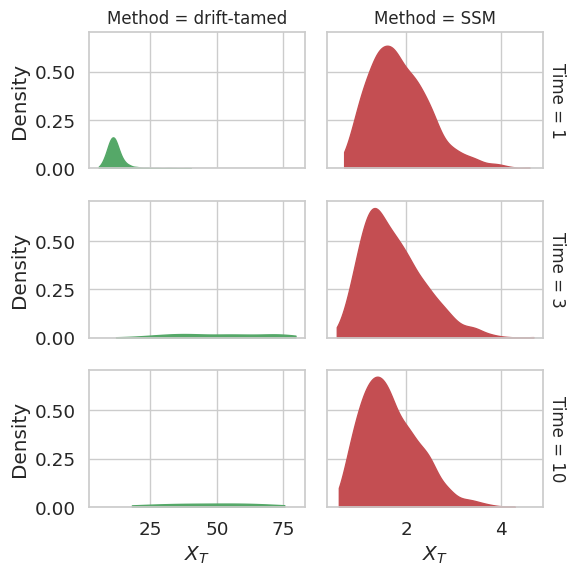

In [ ]:
#make graph (0,1)
#B(100,1), T=1,3,10
newvalue,newnames,newtime=torch_selected_examples(info_time,-30,80)

#sns.plotting_context("notebook", font_scale=5.5)
plt.rcParams['font.size'] = '60'
data = {'Method': newnames, r'$X_T$': newvalue, 'Time': newtime }
df2 = pd.DataFrame(data)
# set seaborn whitegrid theme
sns.set(style="whitegrid",font_scale=1.2)

d = {'color': ['C2', 'C3']}
g = sns.FacetGrid(df2, col="Method",row="Time", hue="Method", margin_titles=True,sharex='col',sharey=True, despine=False,hue_kws=d, height=2, aspect=1.5)
# g = sns.FacetGrid(df2, col="Method",row="Time", hue="Method", margin_titles=True,sharex='col',sharey=True, despine=False,hue_kws=d, height=2, aspect=2.5)
# draw density plots
g = g.map(sns.kdeplot,r'$X_T$', cut=0, fill=True, common_norm=False,alpha=1,  legend=False)
# control the title of each facet
g = g.set_titles("{col_name}",size=12)

# show the graph
plt.show()
g.tight_layout()
g.savefig("FIG-220531-N01-dw.png")

Density-drift-tamed-ssm-(3,3)

In [ ]:
# Compare of different scheme. test part.
# torch.manual_seed(314)
torch.manual_seed(31)

T=1
M=int(2**13)
h=1e-2
n=1000
N=n




bm=torch.zeros(N, dtype=torch.float64)
#bm_for_other_method=[0 for i in range(n)]

bm_time_now=0
bm_time_trigger=[ 10000 for k in range(n_of_scheme) ]

particle_drift_tamed_exact1=torch.zeros(2,N, dtype=torch.float64)
particle_drift_tamed_exact2=torch.zeros(2,N, dtype=torch.float64)
particle_split_step_exact1=torch.zeros(2,N, dtype=torch.float64)
particle_split_step_exact2=torch.zeros(2,N, dtype=torch.float64)
particle_euler_exact1=torch.zeros(2,N, dtype=torch.float64)


#Inital distribution.
for i in range(n):
    xxx000=np.random.normal(0,1)
    # xxx000=random.poisson(10)
    # xxx000=np.random.normal(0,1)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    # xxx000=np.random.binomial(1,0.5)*50
    particle_drift_tamed_exact1[1][i]=xxx000
    particle_drift_tamed_exact2[1][i]=xxx000
    particle_split_step_exact2[1][i]=xxx000
    particle_split_step_exact1[1][i]=xxx000
    particle_euler_exact1[1][i]=xxx000




xxx=0
M=int(1/h)
info_time=[]
ttii=[100,300,1000,3000,5000,8000,10000]
# ttii=[3000,8000,10000,12000,15000,18000,20000]
# ttii=[3000,8000,10000]


torch.manual_seed(3141)
# torch.manual_seed(13)

T=10

# for ii in range(1,20000+1):
for ii in range(1,1000+1):
    time_end=round(ii*h,round_scheme)
    if ii%200==0: print(ii)

    torch_make_brownian_motion(bm,h)
    torch_drift_tamed_method(particle_drift_tamed_exact1,bm,h,T,N)
    torch_ssm_method(particle_split_step_exact1,bm,h,T,N)


    if ii in ttii:
        ttt=ii//100
        method_value=[particle_drift_tamed_exact1,particle_split_step_exact1]
        method_names=[ 'drift-tamed','SSM' ]
        info_time.append(torch_save_information(method_value,method_names,ttt))



200
400
600
800
1000


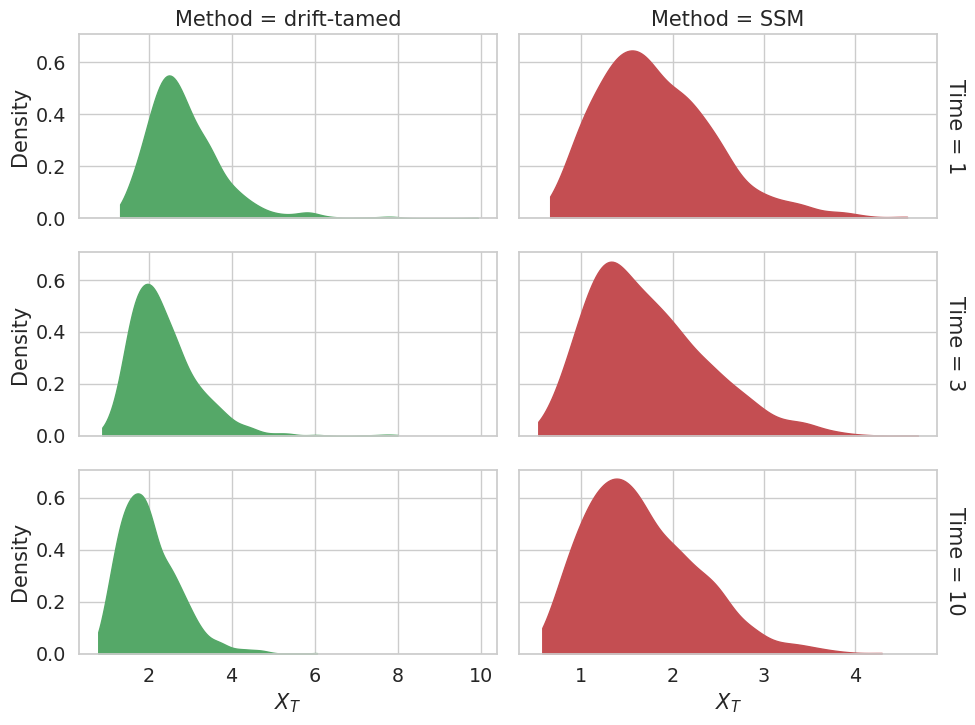

In [ ]:
#N(3,3), T=1,3,10


newvalue,newnames,newtime=torch_selected_examples(info_time,-30,80)



#sns.plotting_context("notebook", font_scale=5.5)
plt.rcParams['font.size'] = '60'
data = {'Method': newnames, r'$X_T$': newvalue, 'Time': newtime }
df3 = pd.DataFrame(data)
# set seaborn whitegrid theme
sns.set(style="whitegrid",font_scale=1.25)

d = {'color': ['C2', 'C3']}
g = sns.FacetGrid(df3, col="Method",row="Time", hue="Method", margin_titles=True,sharex='col',sharey=True, despine=False,hue_kws=d, height=2.5, aspect=2)
# g = sns.FacetGrid(df2, col="Method",row="Time", hue="Method", margin_titles=True,sharex='col',sharey=True, despine=False,hue_kws=d, height=2, aspect=2.5)
# draw density plots
g = g.map(sns.kdeplot,r'$X_T$', cut=0, fill=True, common_norm=False,alpha=1,  legend=False)

# control the title of each facet
g = g.set_titles("{col_name}")

# show the graph
plt.show()
g.tight_layout()
g.savefig("FIG-220531-N39-dw.png")

Density-ME-TE-(0,1)

In [ ]:
# Compare of different scheme. test part.

# hmin=1e-2, N=1000, modified euler,tanh euler, without adaptive.


torch.manual_seed(314)

T=1
M=int(2**13)
h=1e-2
n_of_scheme=8
n=1000
N=n
round_scheme=10



bm=torch.zeros(N, dtype=torch.float64)
#bm_for_other_method=[0 for i in range(n)]

bm_time_now=0
bm_time_trigger=[ 10000 for k in range(n_of_scheme) ]

particle_modified_euler_exact1=torch.zeros(2,N, dtype=torch.float64)
particle_modified_euler_exact2=torch.zeros(2,N, dtype=torch.float64)
particle_tanh_euler_exact1=torch.zeros(2,N, dtype=torch.float64)
particle_tanh_euler_exact2=torch.zeros(2,N, dtype=torch.float64)
particle_euler_exact1=torch.zeros(2,N, dtype=torch.float64)


#Inital distribution.
for i in range(n):
    # xxx000=np.random.normal(4,4)
    xxx000=np.random.normal(3,3)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    # xxx000=np.random.binomial(1,0.5)*100
    particle_modified_euler_exact1[1][i]=xxx000
    particle_modified_euler_exact2[1][i]=xxx000
    particle_tanh_euler_exact1[1][i]=xxx000
    particle_tanh_euler_exact2[1][i]=xxx000
    particle_euler_exact1[1][i]=xxx000




xxx=0
M=int(1/h)
info_time=[]
ttii=[100,300,1000,2000,3000,5000,8000]
# ttii=[3000,8000,10000,12000,15000,18000,20000]
# ttii=[3000,8000,10000]


# torch.manual_seed(3141)
torch.manual_seed(3)

T=10

# for ii in range(1,20000+1):
for ii in range(1,1000+1):
    time_end=round(ii*h,round_scheme)
    if ii%200==0: print(ii)

    torch_make_brownian_motion(bm,h)
    torch_drift_tamed_method(particle_modified_euler_exact1,bm,h,T,N)
    torch_ssm_method(particle_tanh_euler_exact1,bm,h,T,N)

    if ii in ttii:
        ttt=ii//100
        method_value=[particle_modified_euler_exact1,particle_tanh_euler_exact1]
        method_names=['ME','TE' ]
        info_time.append(torch_save_information(method_value,method_names,ttt))




200
400
600
800
1000


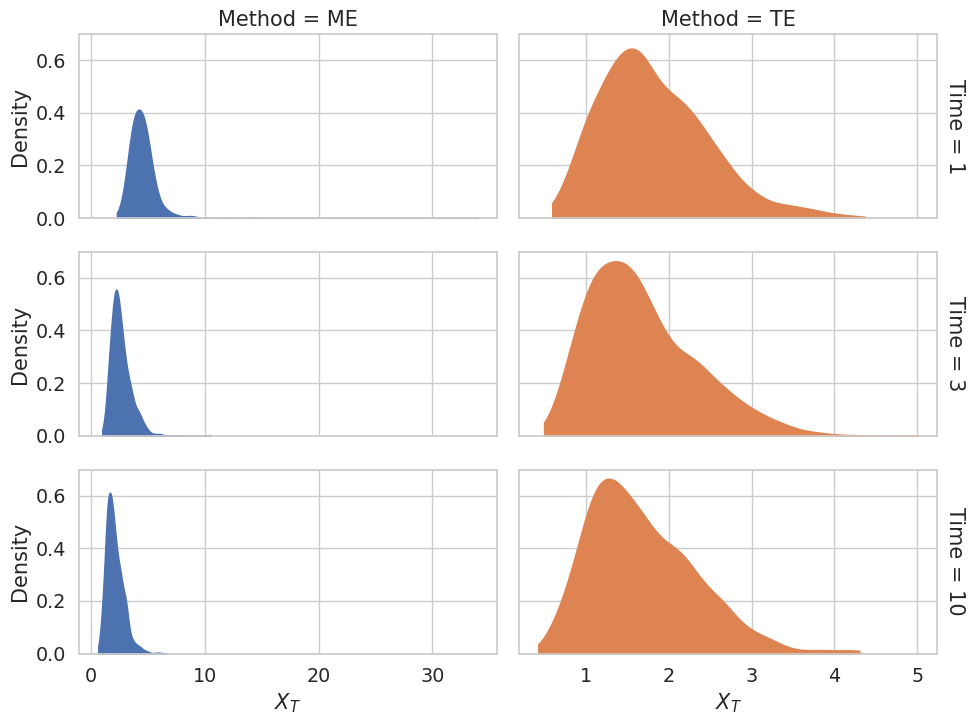

In [ ]:
#make graph (0,1)
#B(100,1), T=1,3,10

newvalue,newnames,newtime=torch_selected_examples(info_time,-30,80)

#sns.plotting_context("notebook", font_scale=5.5)
plt.rcParams['font.size'] = '64'
data = {'Method': newnames, r'$X_T$': newvalue, 'Time': newtime }
df4 = pd.DataFrame(data)
# set seaborn whitegrid theme
sns.set(style="whitegrid",font_scale=1.25)

d = {'color': ['C0', 'C1']}
g = sns.FacetGrid(df4, col="Method",row="Time", hue="Method", margin_titles=True,sharex='col',sharey=True, despine=False,hue_kws=d, height=2.5, aspect=2)
# g = sns.FacetGrid(df2, col="Method",row="Time", hue="Method", margin_titles=True,sharex='col',sharey=True, despine=False,hue_kws=d, height=2, aspect=2.5)
# draw density plots
g = g.map(sns.kdeplot,r'$X_T$', cut=0, fill=True, common_norm=False,alpha=1,  legend=False)
# control the title of each facet
g = g.set_titles("{col_name}")

# show the graph
plt.show()
g.tight_layout()
g.savefig("FIG-220531-N02-dw.png")

Test-ME-TE-Density-(3,3)

In [ ]:
# Compare of different scheme. test part.
# torch.manual_seed(314)
torch.manual_seed(31)

T=1
M=int(2**13)
h=1e-2
n=1000
N=n




bm=torch.zeros(N, dtype=torch.float64)
#bm_for_other_method=[0 for i in range(n)]

bm_time_now=0
bm_time_trigger=[ 10000 for k in range(n_of_scheme) ]

particle_modified_euler_exact1=torch.zeros(2,N, dtype=torch.float64)
particle_modified_euler_exact2=torch.zeros(2,N, dtype=torch.float64)
particle_tanh_euler_exact1=torch.zeros(2,N, dtype=torch.float64)
particle_tanh_euler_exact2=torch.zeros(2,N, dtype=torch.float64)
particle_euler_exact1=torch.zeros(2,N, dtype=torch.float64)


#Inital distribution.
for i in range(n):
    xxx000=np.random.normal(3,3)
    # xxx000=random.poisson(10)
    # xxx000=np.random.normal(0,1)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    # xxx000=np.random.binomial(1,0.5)*50
    particle_modified_euler_exact1[1][i]=xxx000
    particle_modified_euler_exact2[1][i]=xxx000
    particle_tanh_euler_exact1[1][i]=xxx000
    particle_tanh_euler_exact2[1][i]=xxx000
    particle_euler_exact1[1][i]=xxx000




xxx=0
M=int(1/h)
info_time=[]
ttii=[100,300,1000,3000,5000,8000,10000]
# ttii=[3000,8000,10000,12000,15000,18000,20000]
# ttii=[3000,8000,10000]

torch.manual_seed(13)
# torch.manual_seed(13)

T=10

# for ii in range(1,20000+1):
for ii in range(1,1000+1):
    time_end=round(ii*h,round_scheme)
    if ii%200==0: print(ii)

    torch_make_brownian_motion(bm,h)
    torch_modified_euler_method(particle_modified_euler_exact1,bm,h,T,N)
    torch_tanh_euler_method(particle_tanh_euler_exact1,bm,h,T,N)


    if ii in ttii:
        ttt=ii//100
        method_value=[particle_modified_euler_exact1,particle_tanh_euler_exact1]
        method_names=[ 'ME','TE' ]
        info_time.append(torch_save_information(method_value,method_names,ttt))



200
400
600
800
1000


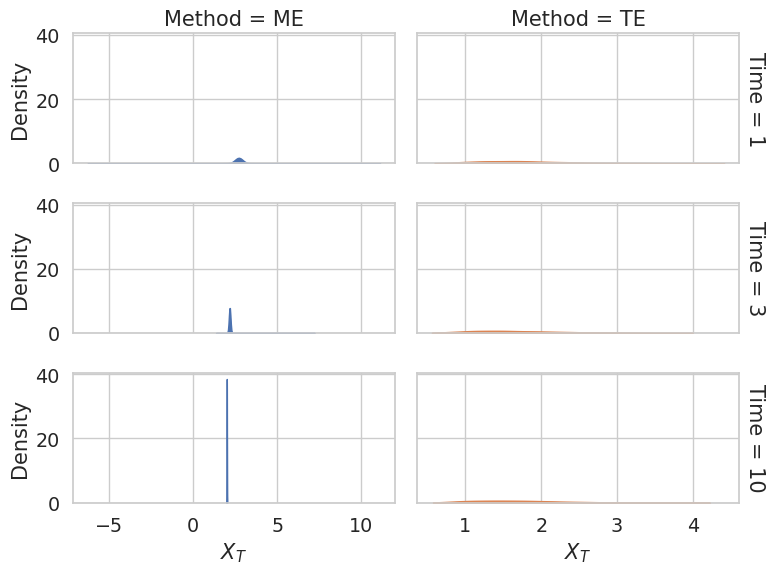

In [ ]:
#N(3,3), T=1,3,10


newvalue,newnames,newtime=torch_selected_examples(info_time,-30,80)

#sns.plotting_context("notebook", font_scale=5.5)
plt.rcParams['font.size'] = '60'
data = {'Method': newnames, r'$X_T$': newvalue, 'Time': newtime }
df = pd.DataFrame(data)
# set seaborn whitegrid theme
sns.set(style="whitegrid",font_scale=1.25)

d = {'color': ['C0', 'C1']}
g = sns.FacetGrid(df, col="Method",row="Time", hue="Method", margin_titles=True,sharex='col',sharey=True, despine=False,hue_kws=d, height=2, aspect=2)
# g = sns.FacetGrid(df2, col="Method",row="Time", hue="Method", margin_titles=True,sharex='col',sharey=True, despine=False,hue_kws=d, height=2, aspect=2.5)
# draw density plots
g = g.map(sns.kdeplot,r'$X_T$', cut=0, fill=True, common_norm=False,alpha=1,  legend=False)

# control the title of each facet
g = g.set_titles("{col_name}")

# show the graph
plt.show()
g.tight_layout()
g.savefig("FIG-220531-N39-dw.png",dpi=100)

### Paths


In [ ]:
# Compare of different scheme. test part.

T=3
M=125
h=0.008
n_of_scheme=1
n=1000
N=n

path_drift_tamed=[[ 0 for i in range(M*T+1) ] for j in  range(N)]
path_euler=[[ 0 for i in range(M*T+1) ] for j in  range(N)]
path_drift_tamed2=[[ 0 for i in range(M*T+1) ] for j in  range(N)]
path_modified_euler=[[ 0 for i in range(M*T+1) ] for j in  range(N)]
path_modified_euler2=[[ 0 for i in range(M*T+1) ] for j in  range(N)]
path_tanh_euler=[[ 0 for i in range(M*T+1) ] for j in  range(N)]
path_tanh_euler2=[[ 0 for i in range(M*T+1) ] for j in  range(N)]
path_ssm=[[ 0 for i in range(M*T+1) ] for j in  range(N)]
path_ada=[[ 0 for i in range(M*T+1) ] for j in  range(N)]

bm=torch.zeros(N, dtype=torch.float64)
particle_drift_tamed_exact1=torch.zeros(2,N, dtype=torch.float64)
#particle_drift_tamed_exact2=torch.zeros(2,N, dtype=torch.float64)
particle_modified_euler_exact1=torch.zeros(2,N, dtype=torch.float64)
#particle_modified_euler_exact2=torch.zeros(2,N, dtype=torch.float64)
particle_tanh_euler_exact1=torch.zeros(2,N, dtype=torch.float64)
#particle_tanh_euler_exact2=torch.zeros(2,N, dtype=torch.float64)
particle_split_step_exact1=torch.zeros(2,N, dtype=torch.float64)
#particle_split_step_exact2=torch.zeros(2,N, dtype=torch.float64)
particle_euler_exact1=torch.zeros(2,N, dtype=torch.float64)
#particle_euler_exact2=torch.zeros(2,N, dtype=torch.float64)


torch.manual_seed(314)

#Inital distribution.  Change the initial conditio here.
for i in range(n):
    xxx000=np.random.normal(3,3)
    #xxx000=1
    #xxx000=np.random.normal(2,100)
    #xxx000=np.random.binomial(1,0.5)*101-1
    particle_drift_tamed_exact1[1][i]=xxx000
    particle_modified_euler_exact1[1][i]=xxx000
    particle_tanh_euler_exact1[1][i]=xxx000
    # particle_drift_tamed_exact2[1][i]=xxx000
    # particle_split_step_exact2[1][i]=xxx000
    particle_split_step_exact1[1][i]=xxx000
    # particle_euler_exact1[1][i]=xxx000
    # particle_euler_exact2[1][i]=xxx000

ii=0
for j in range(N):
    path_euler[j][ii]=particle_euler_exact1[1][j].item()
    #path_drift_tamed2[j][ii]=particle_drift_tamed_exact2[1][j].item()
    path_drift_tamed[j][ii]=particle_drift_tamed_exact1[1][j].item()
    #path_modified_euler2[j][ii]=particle_modified_euler_exact2[1][j].item()
    path_modified_euler[j][ii]=particle_modified_euler_exact1[1][j].item()
    #path_tanh_euler2[j][ii]=particle_tanh_euler_exact2[1][j].item()
    path_tanh_euler[j][ii]=particle_tanh_euler_exact1[1][j].item()
    path_ssm[j][ii]=particle_split_step_exact1[1][j].item()

xxx=0
M=int(1/h)
torch.manual_seed(0) # change the seed
for ii in range(1,M*T+1):
# for ii in range(1,10+1):

    if ii%100==0: print(ii)

    torch_make_brownian_motion(bm,h)
    torch_drift_tamed_method(particle_drift_tamed_exact1,bm,h,T,N)
    torch_modified_euler_method(particle_modified_euler_exact1,bm,h,T,N)
    torch_tanh_euler_method(particle_tanh_euler_exact1,bm,h,T,N)
    torch_ssm_method(particle_split_step_exact1,bm,h,T,N)

    for j in range(N):
        path_drift_tamed[j][ii]=particle_drift_tamed_exact1[1][j].item()
        path_modified_euler[j][ii]=particle_modified_euler_exact1[1][j].item()
        path_tanh_euler[j][ii]=particle_tanh_euler_exact1[1][j].item()
        path_ssm[j][ii]=particle_split_step_exact1[1][j].item()


100
200
300
400
500
600
700


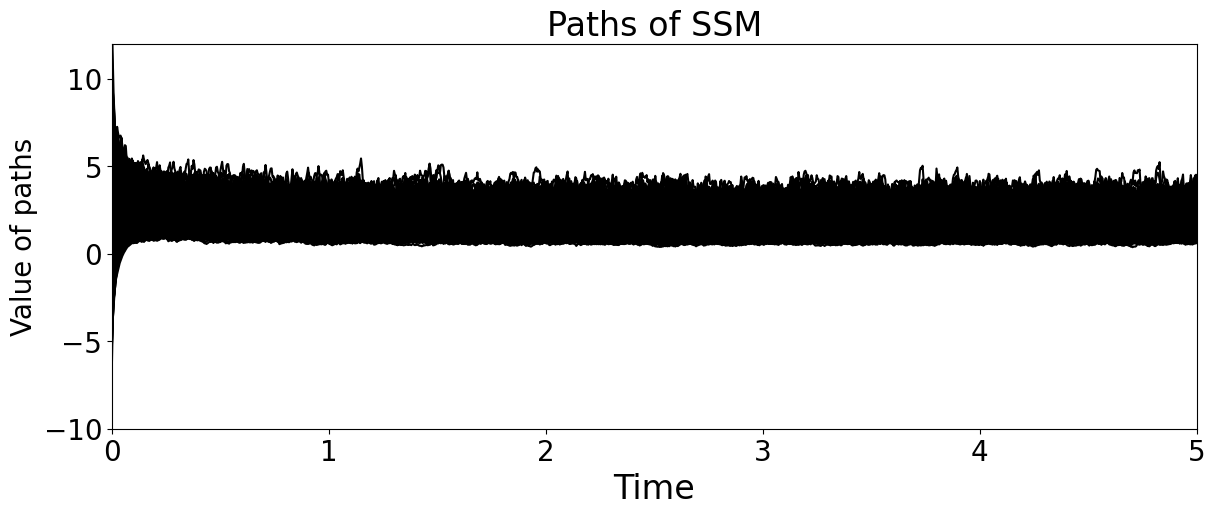

In [ ]:
### Plotting part
N=1000
axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (14,5)
plt.rcParams['font.size'] = '20'
plt.xlabel('Time', fontsize=24)
plt.ylabel('Value of paths', fontsize=20)
plt.title('Paths of SSM')
#plt.title('Paths of Euler scheme with partical corruption')
plt.xlim(0, T)
plt.ylim(-10.0, 12.0)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')


for i in range(0,N):
    cc='black'
#     for j in range(0,20):
#         if path[i][j]<-8: cc='red'
    plt.plot( axiss,path_ssm[i],color=cc)


plt.savefig('Paths-ssm.png',dpi=600)

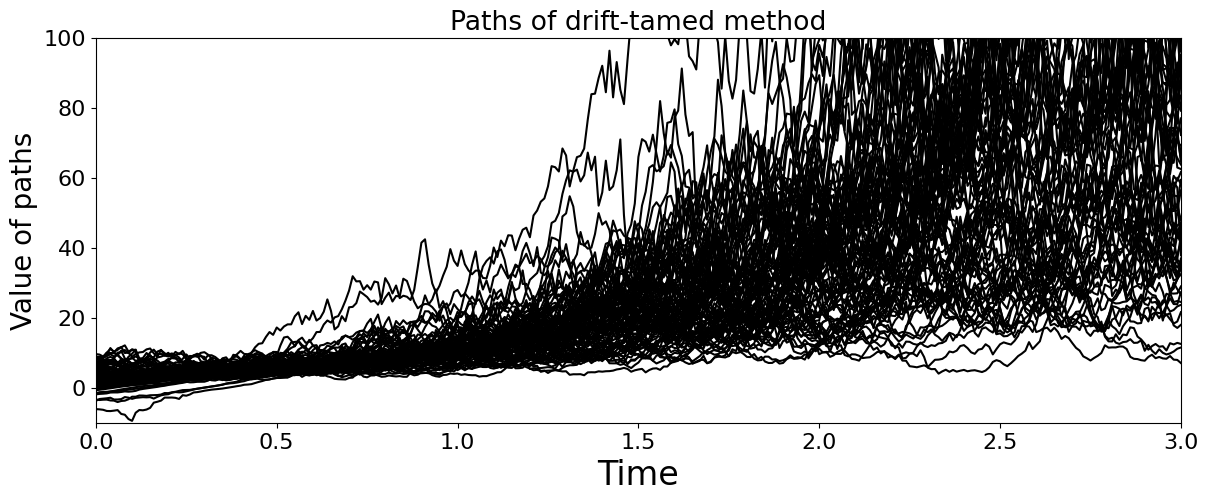

In [ ]:
### Plotting part  drift_tamed

plt.rcParams['font.size'] = '16'
N=100
axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (14,5)
plt.xlabel('Time', fontsize=24)
plt.ylabel('Value of paths', fontsize=20)
plt.title('Paths of drift-tamed method')
#plt.title('Paths of Euler scheme with partical corruption')
plt.xlim(0, T)
plt.ylim(-10, 100)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')


for i in range(0,N):
    cc='black'
#     for j in range(0,20):
#         if path[i][j]<-8: cc='red'
    plt.plot( axiss,path_drift_tamed[i],color=cc)


plt.savefig('Paths-tam.png',dpi=600)

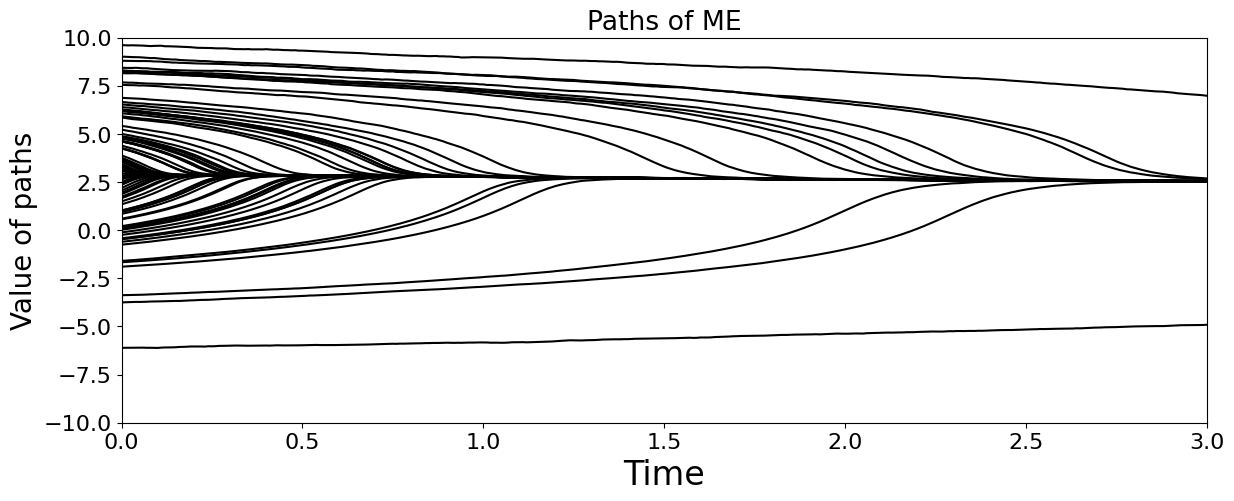

In [ ]:
### Plotting part modified Euler method

plt.rcParams['font.size'] = '16'
N=100
axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (14,5)
plt.xlabel('Time', fontsize=24)
plt.ylabel('Value of paths', fontsize=20)
plt.title('Paths of ME')
#plt.title('Paths of Euler scheme with partical corruption')
plt.xlim(0, T)
plt.ylim(-10, 10)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')


for i in range(0,N):
    cc='black'
#     for j in range(0,20):
#         if path[i][j]<-8: cc='red'
    plt.plot( axiss,path_modified_euler[i],color=cc)


plt.savefig('Paths-modified-Euler.png',dpi=600)

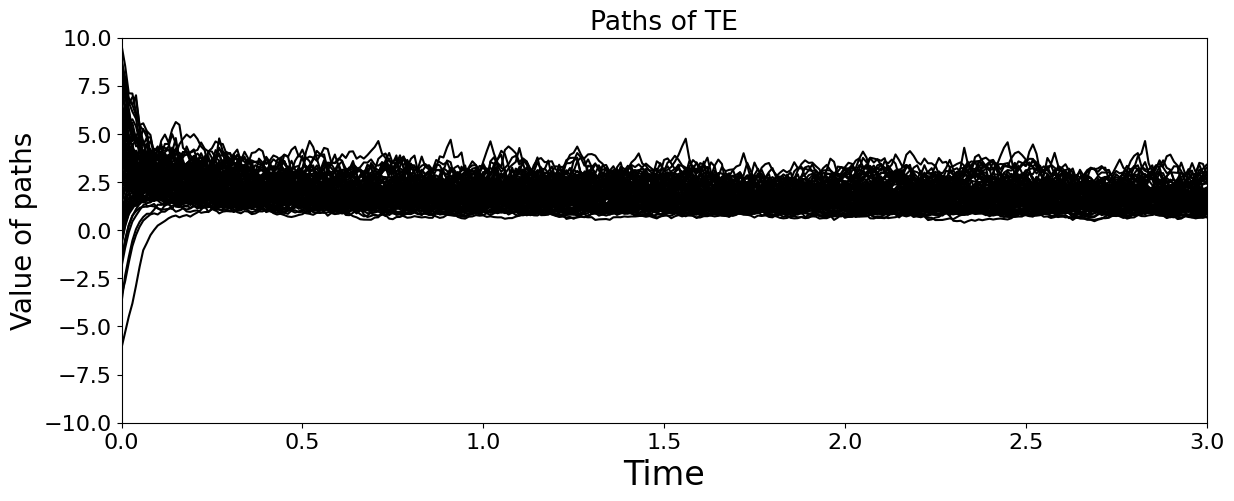

In [ ]:
### Plotting tanh tamed

plt.rcParams['font.size'] = '16'
N=100
axiss=[]
for i in range(0,M*T+1):
    axiss.append(i*h)
plt.rcParams["figure.figsize"] = (14,5)
plt.xlabel('Time', fontsize=24)
plt.ylabel('Value of paths', fontsize=20)
plt.title('Paths of TE')
#plt.title('Paths of Euler scheme with partical corruption')
plt.xlim(0, T)
plt.ylim(-10, 10)
#for i in range(0,N):     plt.plot( axiss,path[i],color='black')


for i in range(0,N):
    cc='black'
#     for j in range(0,20):
#         if path[i][j]<-8: cc='red'
    plt.plot( axiss,path_tanh_euler[i],color=cc)


plt.savefig('Paths-tanh-tamed.png',dpi=600)